In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pyspark.sql.functions import col, udf, explode
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf().setAll([
    ('spark.executor.instances','1'),
    ('spark.network.timeout', '3601s'),
    ('spark.executor.heartbeatInterval', '3600s'),
])
sc = ps.SparkContext('local', conf=config)
spark = SparkSession(sc)

import pyspark.pandas as ps
from pyspark_dist_explore import hist

from pyspark.sql.functions import year, month

In [2]:
plt.style.use("ggplot")

In [3]:
!PowerShell.exe gc "./data/generated/yt_metadata_en_urls.parquet" -head 2

gc : L'acc�s au chemin d'acc�s 'C:\Projet MA1\Ada\project_Youniverse\ada-2022-project-fraisetagada\ada-2022-project-fra
isetagada\data\generated\yt_metadata_en_urls.parquet' est refus�.
Au caract�re Ligne:1 : 1
+ gc ./data/generated/yt_metadata_en_urls.parquet -head 2
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : PermissionDenied: (C:\Projet MA1\A...en_urls.parquet:String) [Get-Content], Unauthorized 
   AccessException
    + FullyQualifiedErrorId : GetContentReaderUnauthorizedAccessError,Microsoft.PowerShell.Commands.GetContentCommand
 


In [3]:
FILE = "data/generated/yt_metadata_en_urls.parquet"

schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("urls", ArrayType(StringType()), True),
    StructField("urls_count", DoubleType(), True),
    StructField("has_urls", BooleanType(), True),
])

In [4]:
df = spark.read.parquet(FILE, schema=schema)


In [6]:
df.show(2, vertical = True)

-RECORD 0-----------------------------
 categories    | Howto & Style        
 channel_id    | UCROB2-0bJEcwiP05... 
 crawl_date    | 2019-11-17           
 dislike_count | null                 
 display_id    | iICAtB8ViFM          
 duration      | 1365                 
 like_count    | null                 
 tags          | makeup geek,kathl... 
 title         | Makeup Haul | Cha... 
 upload_date   | 2016-08-22           
 view_count    | 2813                 
 urls          | [http://go.magik.... 
 urls_count    | 14                   
 has_urls      | true                 
-RECORD 1-----------------------------
 categories    | Howto & Style        
 channel_id    | UCROB2-0bJEcwiP05... 
 crawl_date    | 2019-11-17           
 dislike_count | null                 
 display_id    | BjJMZEqRJU8          
 duration      | 1289                 
 like_count    | null                 
 tags          | ride or die,tag,j... 
 title         | The Ride Or Die M... 
 upload_date   | 2016-08-

In [5]:
# Cast the dislike_count, like_count and view_count to their respective integer type
df = df \
    .withColumn("dislike_count", df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", df.like_count.cast(IntegerType())) \
    .withColumn("view_count", df.view_count.cast(LongType()))\
    .withColumn("has_urls",df['has_urls'].cast(BooleanType()))\
    .withColumn("urls_count",df['urls_count'].cast(IntegerType()))

In [51]:
df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- urls_count: integer (nullable = true)
 |-- has_urls: boolean (nullable = true)



In [62]:
df.select(df["dislike_count"],df["like_count"], df["duration"], df["view_count"], df["urls_count"]).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|        like_count|          duration|        view_count|        urls_count|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          71293336|          71293336|          72924794|          72924140|          72924794|
|   mean|  76.0915862037933|1306.7580320831107| 757.6761375561788|125237.60820707656|1.8920509394925407|
| stddev|3064.7580067517706|20135.880453098183|1820.1105064271228| 3534488.216722468|3.6126438800238967|
|    min|                 0|                 0|                 1|                 0|                 0|
|    25%|                 0|                 6|               134|               533|                 0|
|    50%|                 2|                43|               284|              2926|                 1|
|    75%|                12|               266|        

## Total number of video containing urls

The count is $39635552$

In [8]:
df_urls = df.where(df["has_urls"] == "true")
df_urls.count()

39635552

In [75]:
df_urls.select(df_urls["dislike_count"],df_urls["like_count"], df_urls["duration"], df_urls["view_count"], df_urls["urls_count"]).summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|        like_count|          duration|        view_count|        urls_count|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|          38832948|          38832948|          39635552|          39635121|          39635552|
|   mean| 96.64598407517245|1794.6333588683506| 826.2556941051307|164725.98607447167|3.4811531071902317|
| stddev|3979.7913427365856| 26156.84896760549|1920.2010232393127| 4558197.649328211|4.2989266847036545|
|    min|                 0|                 0|                 1|                 0|                 1|
|    25%|                 0|                12|               152|               852|                 1|
|    50%|                 3|                73|               325|              4455|                 2|
|    75%|                18|               425|        

# Show the number of urls video posted each month

In [9]:
df_dates = df_urls\
    .withColumn("year", year(df_urls.upload_date))\
    .withColumn("month", month(df_urls.upload_date))
df_dates.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- urls_count: integer (nullable = true)
 |-- has_urls: boolean (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [83]:
# Group the videos by year and month and count the number of such videos
vids_per_month = df_dates.select("display_id", "year", "month").groupBy("year", "month").count()

In [84]:
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count = vids_per_month.toPandas()

In [85]:
count_sorted = count.sort_values(["year", "month"])

In [86]:
count_sorted["date"] = pd.to_datetime(count_sorted["year"].astype(str) + count_sorted["month"].astype(str), format="%Y%m")

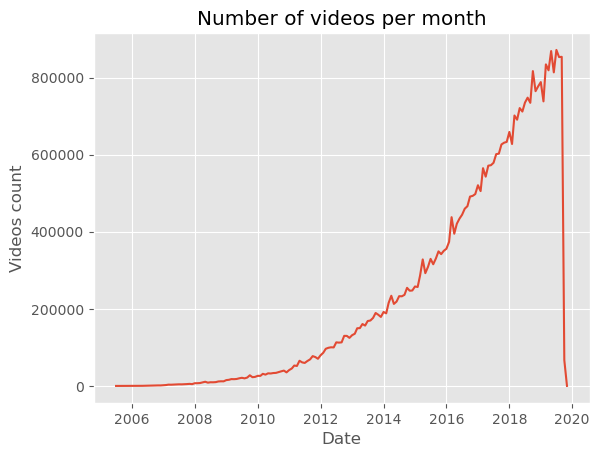

In [91]:
sns.lineplot(data=count_sorted, x="date", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()

# Group videos containing URLs by year and categories

In [92]:
# Group the videos by year and month and count the number of such videos
vids_per_month_per_cat = df_dates.select("display_id", "categories", "year").groupBy("year", "categories").count()

In [93]:
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat = vids_per_month_per_cat.toPandas()

In [96]:
cats = set()
for x in count_cat.categories:
    cats.add(x)
cats

{'',
 'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Movies',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events'}

In [97]:
count_cat_idx = count_cat.set_index(['year', 'categories'])

In [98]:
count_cat_idx = count_cat_idx.unstack(fill_value=0)["count"].unstack().reset_index(name='count').reset_index()

In [99]:
stack = {}
years = range(2005, 2020)
for cat in cats:
    stack[cat] = count_cat_idx[count_cat_idx["categories"] == cat].sort_values("year")["count"].values
stack['None'] = stack.pop('')

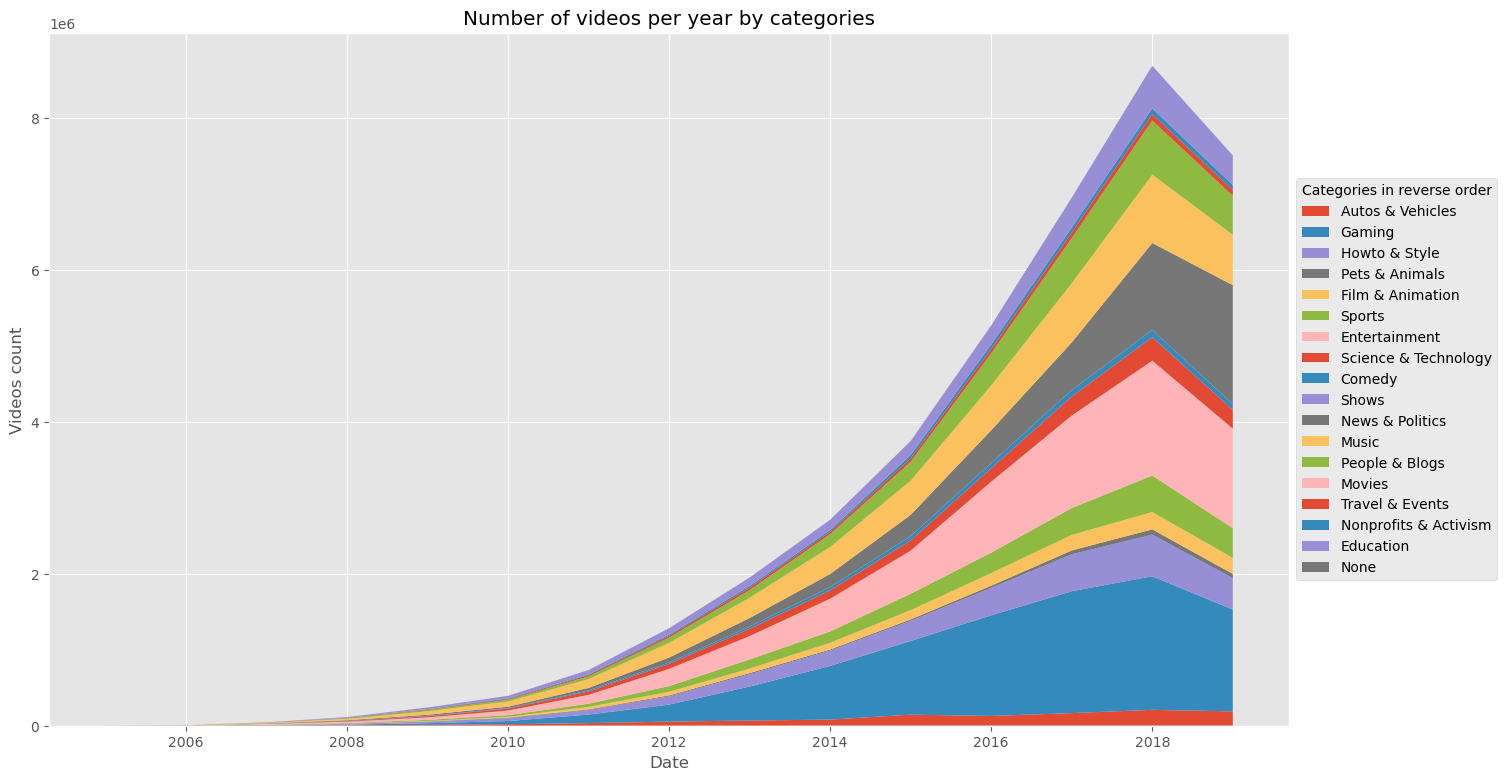

In [102]:
plt.figure(figsize=(16, 9))
# ax = sns.FacetGrid(data=count_cat, x="year", y="count", hue="categories", palette=sns.color_palette("Paired"))
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# for k, v in stack.items():
#     plt.bar(years, v, label=k)
plt.stackplot(years, stack.values(), labels=stack.keys())
plt.title("Number of videos per year by categories")
plt.xlabel("Date")
plt.ylabel("Videos count")
# plt.yscale('log')
plt.legend(
    title="Categories in reverse order", loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.show()

In [103]:
count_cat_idx = count_cat_idx.drop("index", axis=1)

In [104]:
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()

In [105]:
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())

In [106]:
# Verify that the sum of all ratios gives 100%
ratios.groupby("year")["ratio"].sum()

year
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
Name: ratio, dtype: float64

In [107]:
ratios.categories = ratios.categories.replace('', 'None')

In [108]:
# Ratios per category in 2011
ratios[ratios.year == 2011]

,categories,year,count,ratio
6,None,2011,19,0.000026
21,Autos & Vehicles,2011,34098,0.046512
36,Comedy,2011,13733,0.018733
51,Education,2011,55740,0.076033
66,Entertainment,2011,117063,0.159681
81,Film & Animation,2011,33428,0.045598
96,Gaming,2011,112882,0.153978
111,Howto & Style,2011,60588,0.082646
126,Movies,2011,0,0.000000
141,Music,2011,116437,0.158827


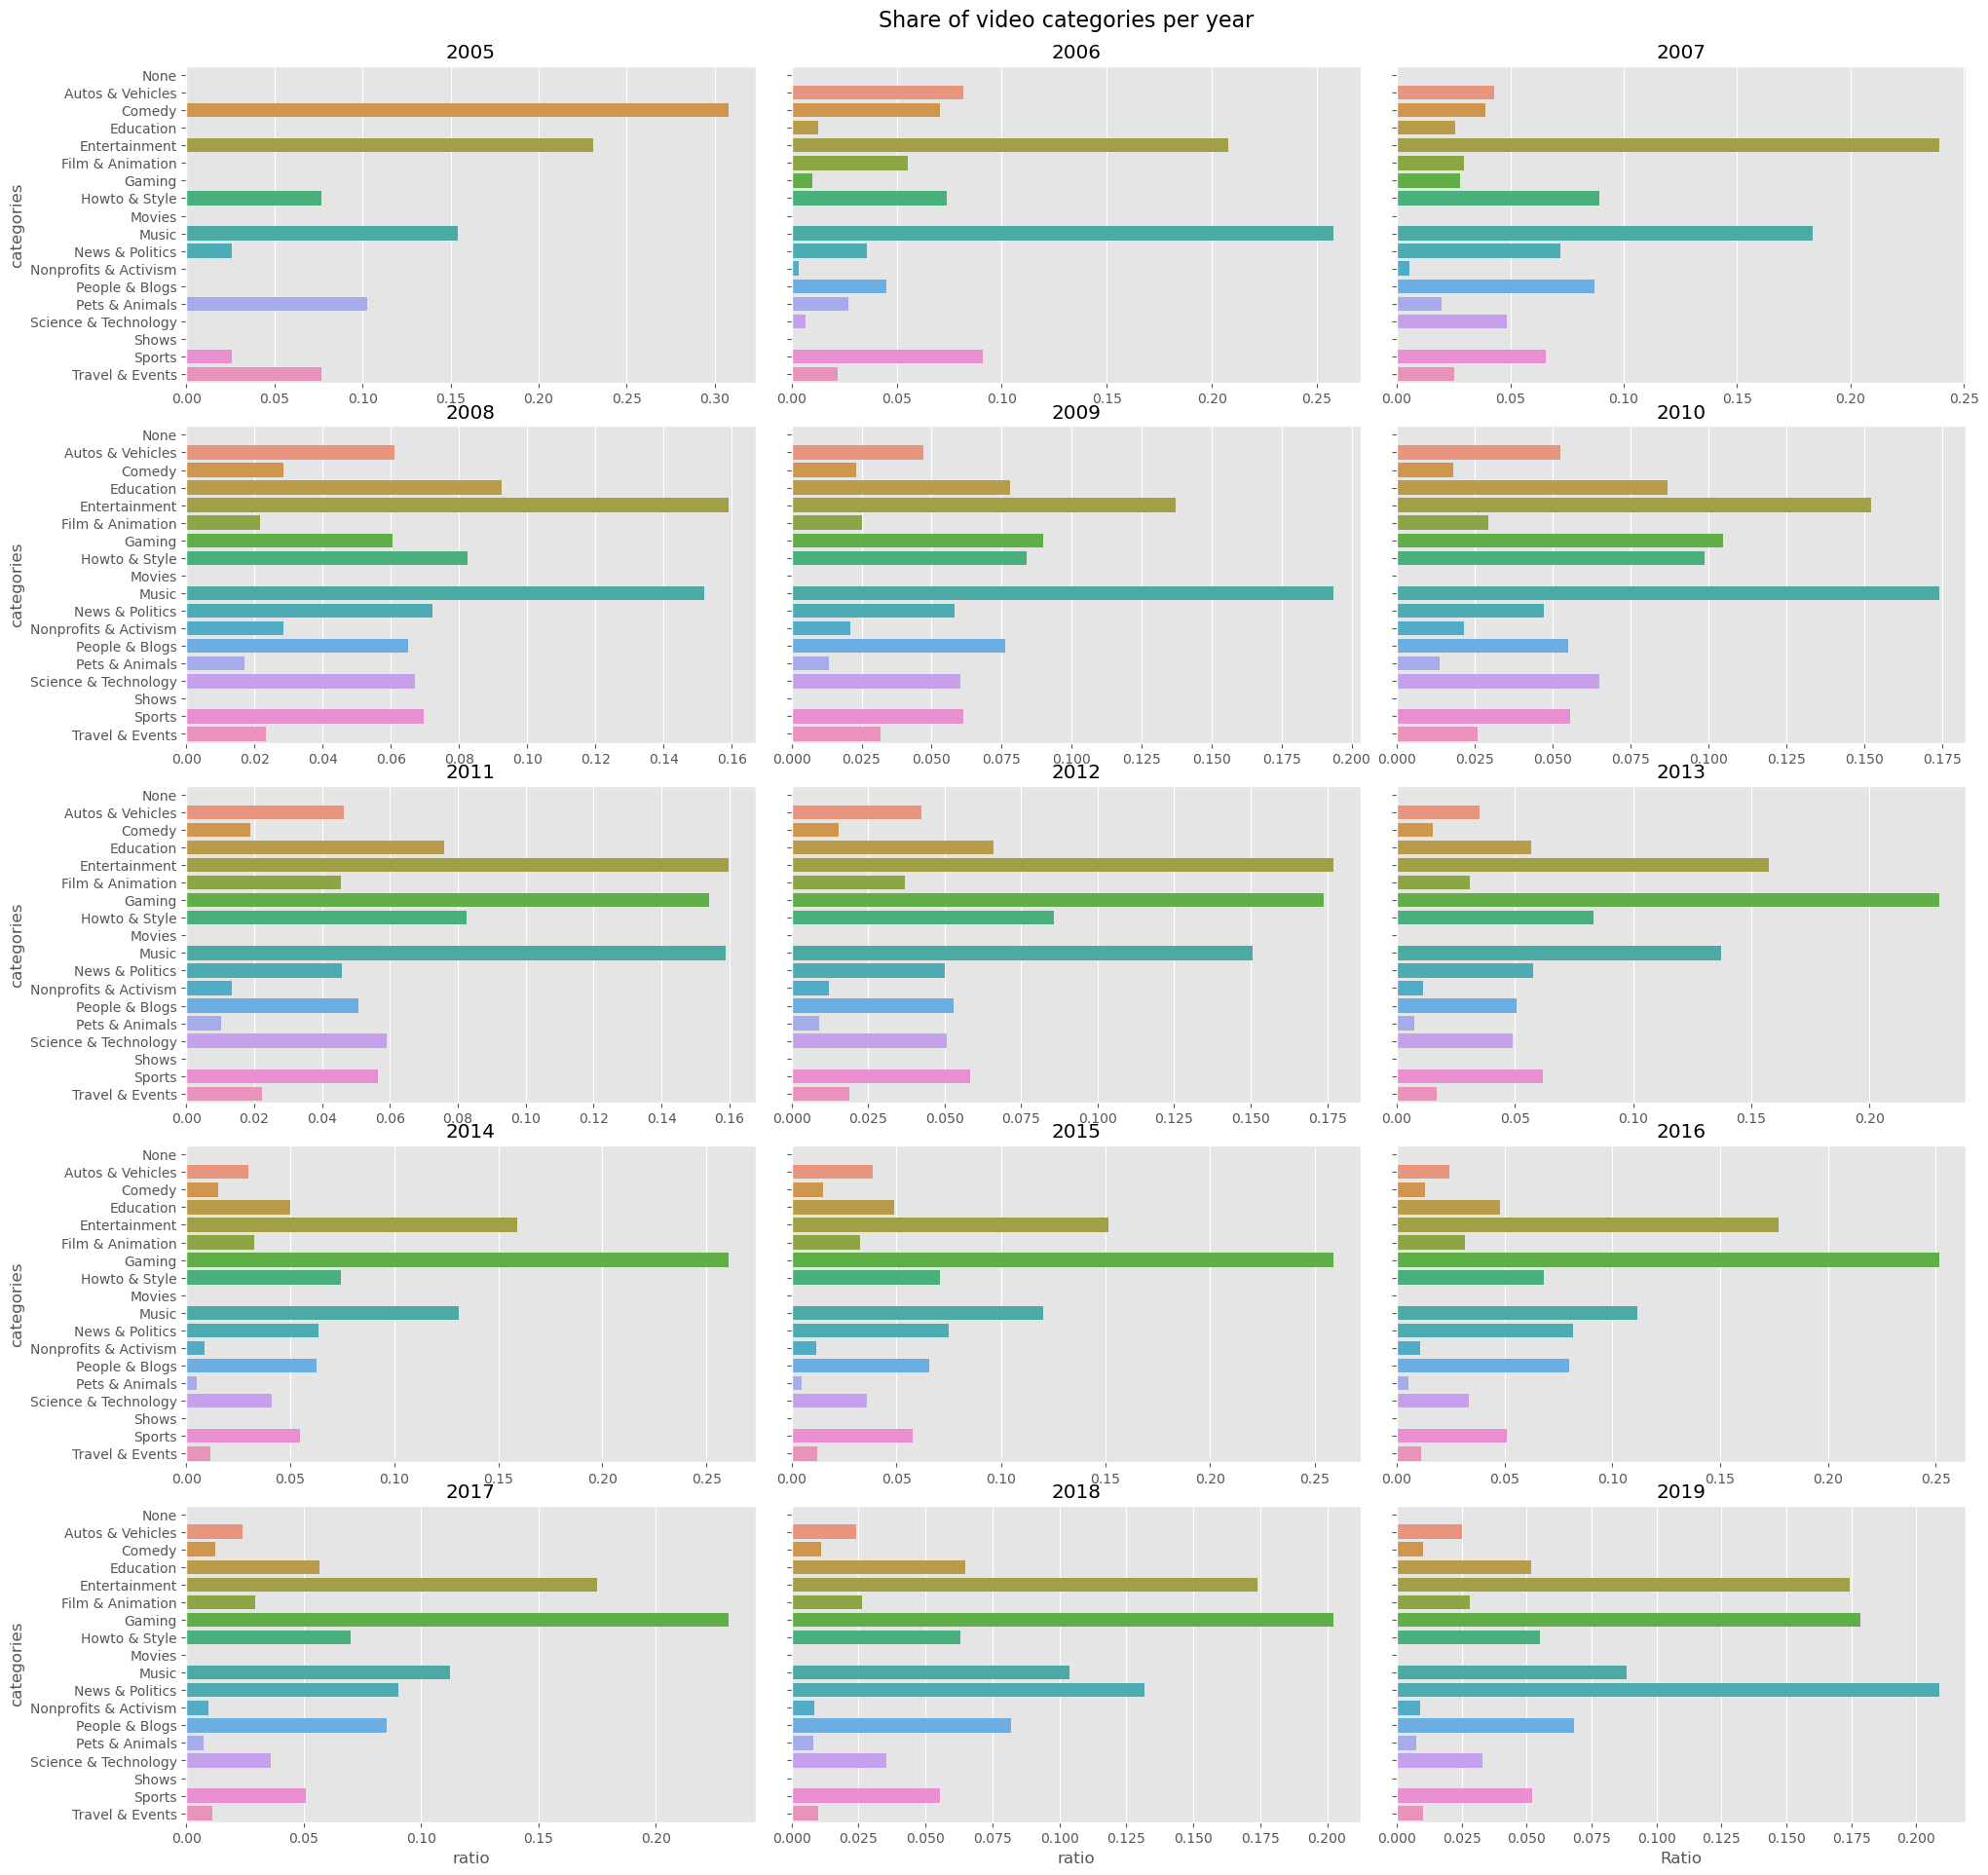

In [109]:
fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()
for year, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax, data=ratios[ratios["year"] == year], y="categories", x="ratio"
    )
    idx = year - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(year)

plt.xlabel("Ratio")
plt.show()

# Group video without URLs by year and categories

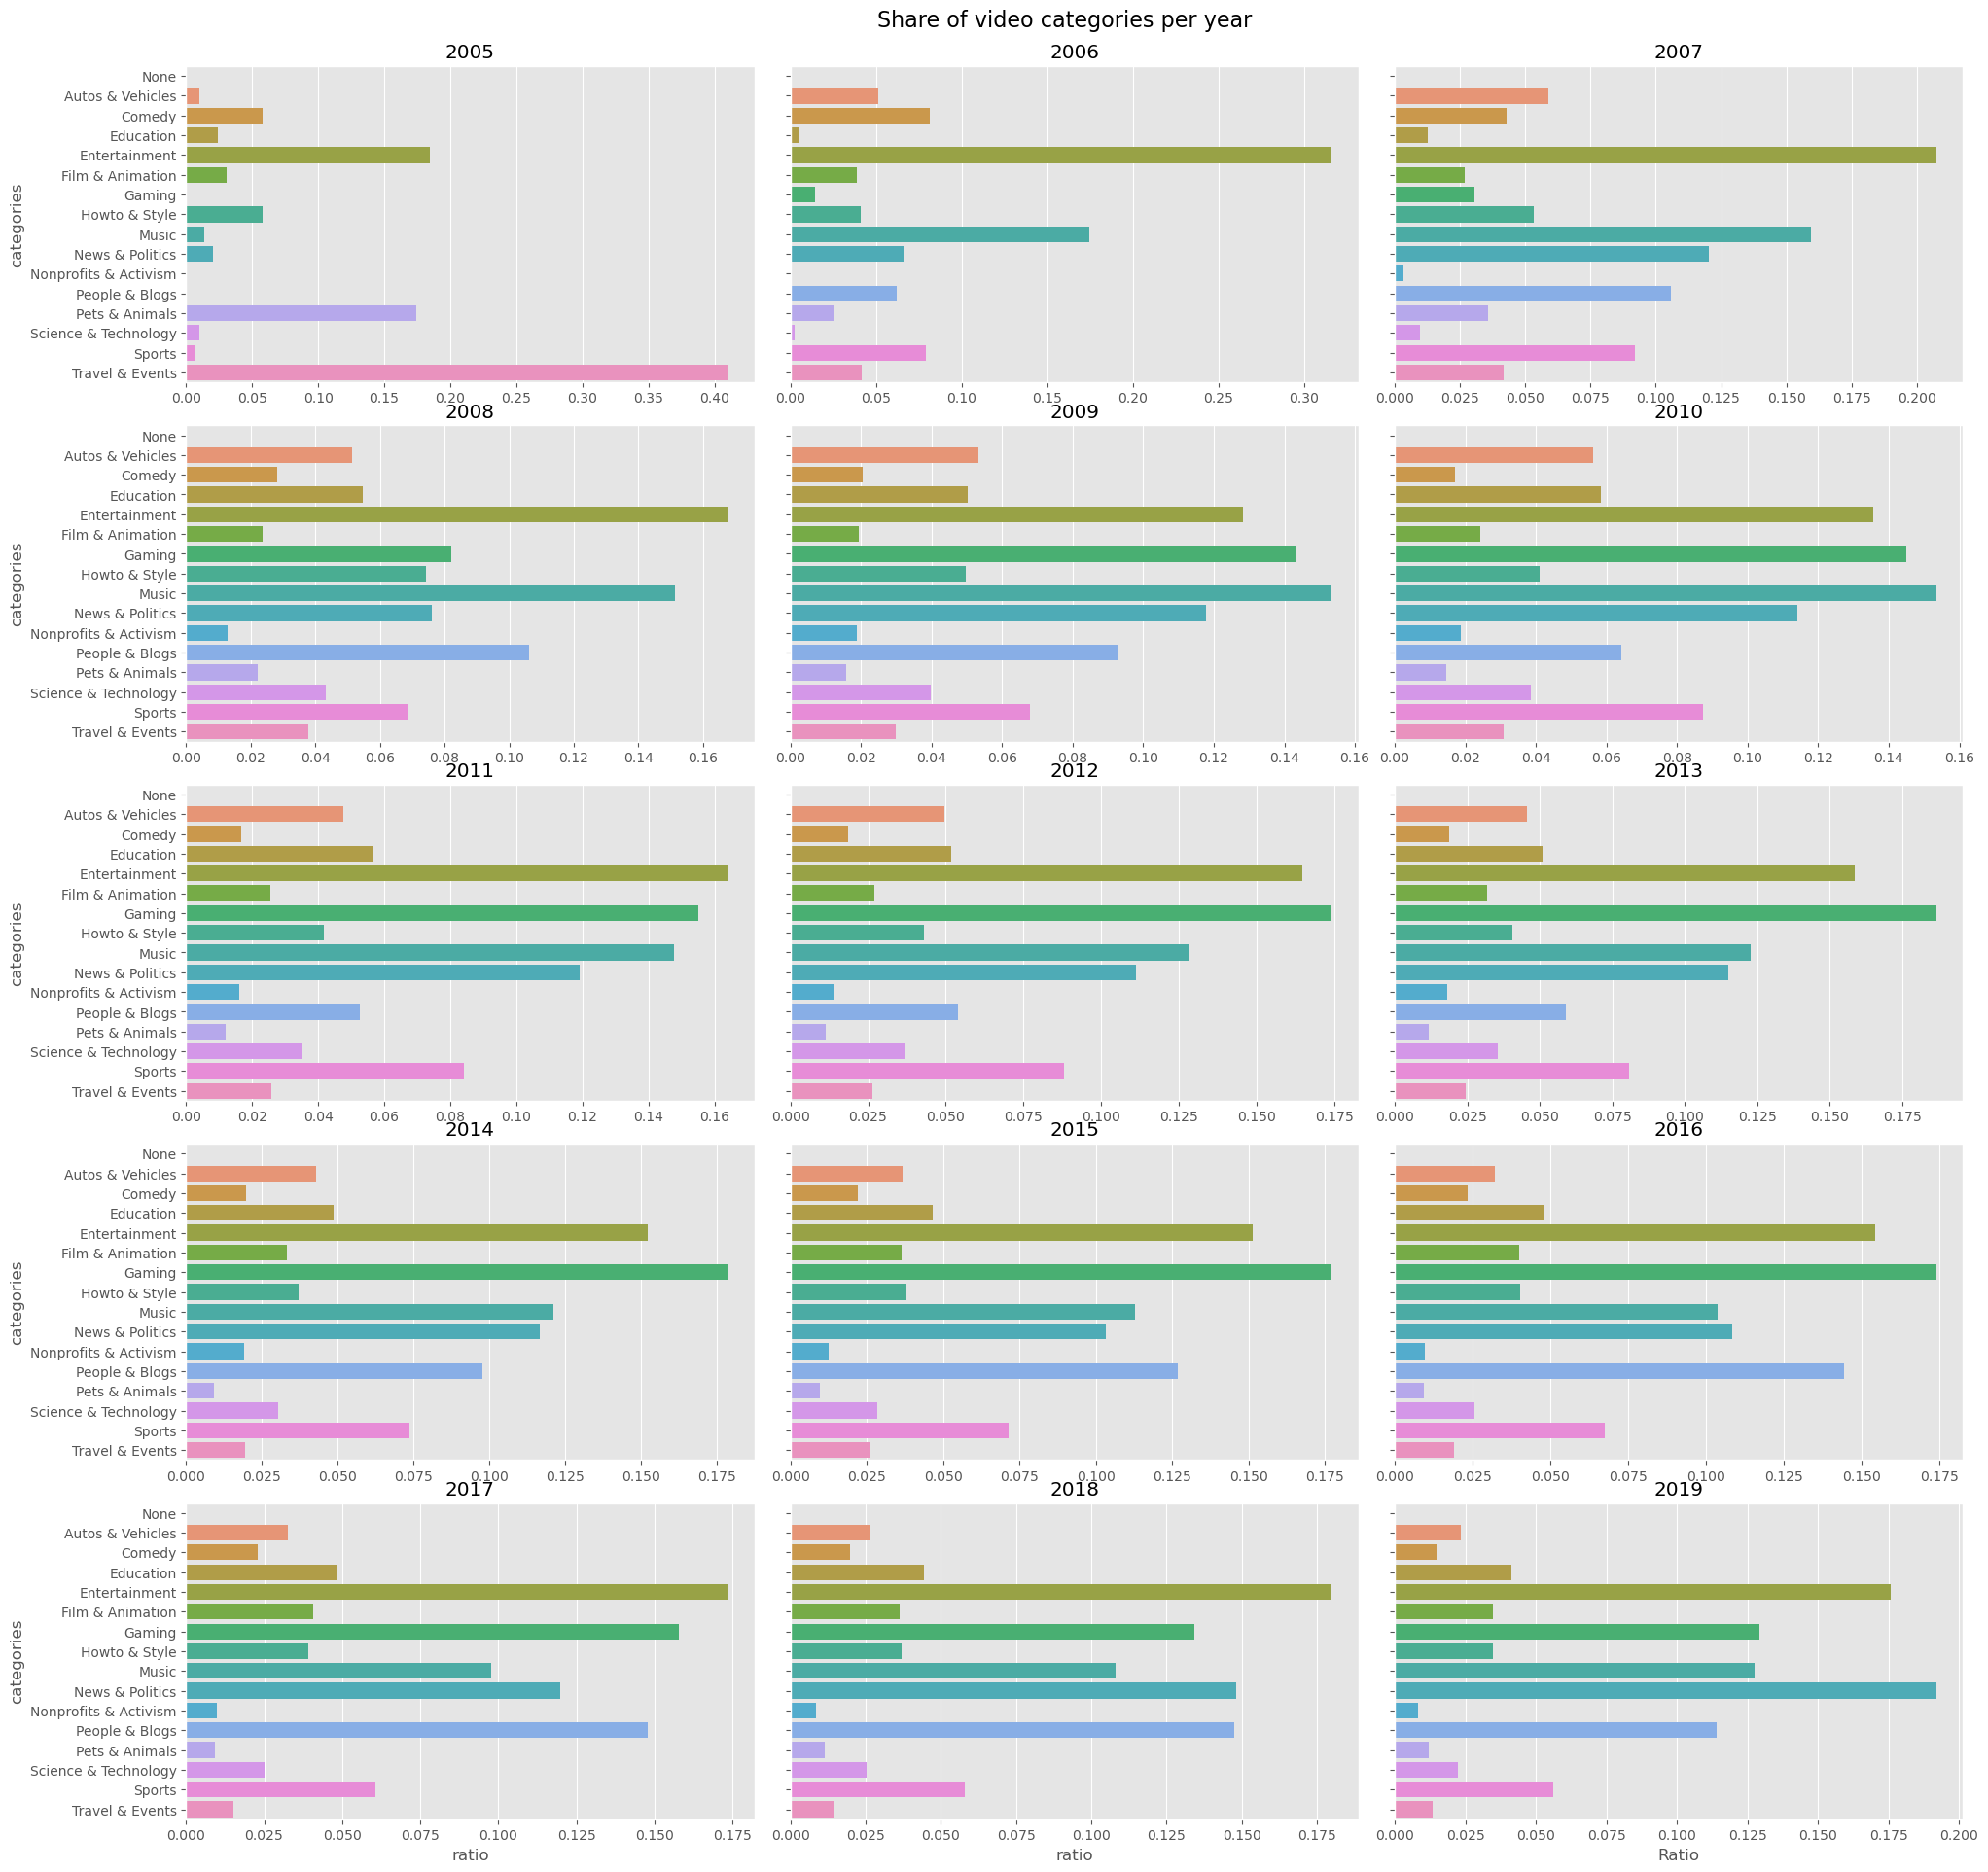

In [6]:
df_no_urls = df.where(df["has_urls"] == "false")
# Group the videos by year and month and count the number of such videos
df_dates = df_no_urls.withColumn("year", year(df_no_urls.upload_date)).withColumn("month", month(df_no_urls.upload_date))
vids_per_month_per_cat = df_dates.select("display_id", "categories", "year").groupBy("year", "categories").count()
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat = vids_per_month_per_cat.toPandas()
count_cat_idx = count_cat.set_index(['year', 'categories']).unstack(fill_value=0)["count"].unstack().reset_index(name='count').reset_index().drop("index", axis=1)
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())
ratios.categories = ratios.categories.replace('', 'None')

fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()

years = range(2005, 2020)
for year, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax, data=ratios[ratios["year"] == year], y="categories", x="ratio"
    )
    idx = year - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(year)

plt.xlabel("Ratio")
plt.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 49) (128.179.156.95 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


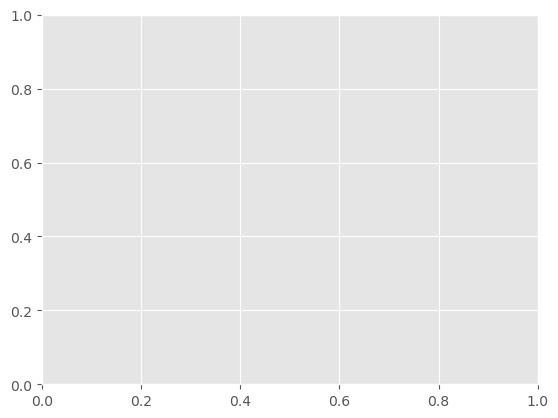

In [7]:
fig, ax = plt.subplots()
hist(ax, df_no_urls.select('like_count'), bins = 20, color=['red'])

# Number of URLs per video in time

In [150]:
urls_vid_per_year = df_dates.select("display_id", "year", "urls_count").groupBy("year").count()
count = urls_vid_per_year.toPandas()

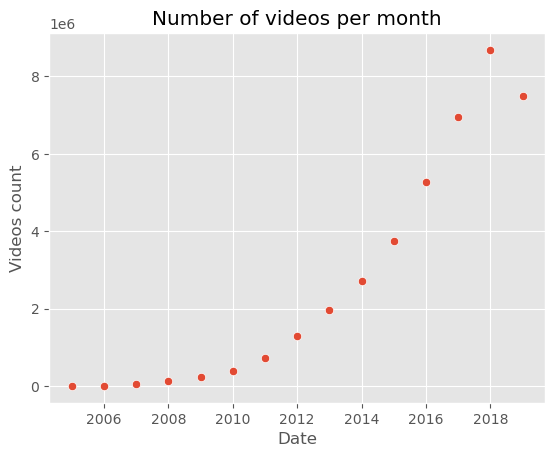

In [151]:
sns.scatterplot(data=count, x="year", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()